In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils

random_wav = "bass_electronic_018-022-100.wav"


In [19]:
audio = utils.load_audio(random_wav)
sample_length = audio.shape[0]
print(sample_length)
audio = np.concatenate((audio, audio))

64000


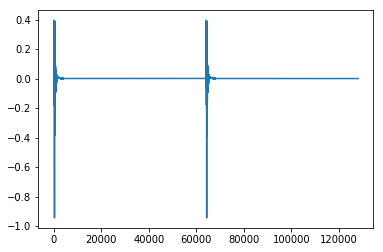

In [20]:
%matplotlib inline
plt.plot(audio)
plt.show()

In [21]:
print(audio)

[  0.00000000e+00   6.10351562e-05   2.13623047e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [ ]:
class Autoencoder
    def __init__(self, bidirectional=True, lsmt_units = 512):
        self.ae_hop_length = 512
        self.num_iter = 10000
        self.learning_rate = 0.00001
        self.batch_size = 100
        self.lstm_units = lstm_units
    def get_batch():
        batch_size = self.batch_size
        #TODO:get batch
        pass
    def build(inputs):
        #get input from wav file
        x = inputs['wav']
        x_quantized = utils.mu_law(x)
        x_scaled = tf.cast(x_quantized, tf.float32) / 128.0
        x_scaled = tf.expand_dims(x_scaled, 2)
        num_z = 16
    
        embedding = tf.placeholder(name="embedding", shape=[batch_size, num_z], dtype=tf.float32)
        en = tf.expand_dims(encoding, 1)
        
        #TODO: build an autoencoder
        global_step = tf.Variable(0, name="global step", trainable = False)    

        initializer = tf.contrib.layers.xavier_initializer()
        self.lstm_fw = tf.nn.rnn_cell.LSTMCell(lstm_units,
                                               initializer=initializer)
        self.lstm_bw = tf.nn.rnn_cell.LSTMCell(lstm_units,
                                               initializer=initializer)
        shape = (lstm_units, num_z)
        self.projection_w = tf.get_variable('projection_w', shape,
                                            initializer=initializer)
        self.projection_b = tf.get_variable('projection_b',shape =(self.vocab_size,), initializer=tf.zeros_initializer())
        #embedded = tf.nn.embedding_lookup(self.embeddings, self.sentence)
        #embedded = tf.nn.dropout(embedded, self.dropout_keep)
        #ret = tf.nn.dynamic_rnn(self.lstm_fw, embedded, dtype=tf.float32,sequence_length=self.sentence_zie)
                                               
    return {
        'predictions': probs,
        'loss': loss,
        'eval': {
            'nll': loss
        },
        'quantized_input': x_quantized,
        'encoding': encoding,
    }